# DSCI 591: Data Science Capstone I <br> Model Development on FLAME 1 Dataset

## Project Objective

1. Build model to detect the presence of forest fires
2. Build model to detect border / boundary of forest fire

## Primary Use Case

Park rangers pilot drones to at-risk locations for surveillance and early fire detection. Data is relayed as input for the model.

## Import Relevant libraries

First, we will import the libraries needed for our model development. These will be broken up by their uses.

In [1]:
#General Use
import numpy as np
import random
import itertools

#Model Development
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose

#Model Analysis / Evaluation
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from skimage.io import imshow
import matplotlib.pyplot as plt

#Saving models
import pickle 

## Import and Prepare Dataset

First, we will establish the training directory. Again, this dataset contains both true "Fire" labels and false "No_Fire" labels. We also will specify the image sizing of interest - here, a square of 256x256.

In [2]:
## Set current TRAIN directory
local_train_dir = "C:\\Users\\ConnorRoth\\Documents\\Grad School\\Spring 2023\\DSCI 591\\Datasets\\FLAME 1\\Training"

In [3]:
#Establish image sizing
image_size = (256, 256)

Next, we will establish the training and validation image datasets from TensorFlow's Keras module. Specifically, we will have an 80/20 training/validation split and establish a batch size of 32. The final area of note is establishing a seed value so that this split is replicable.

We'll then pre-fetch the datsets to make sure everything is prepared.

In [4]:
#Establish training and validation datasets, 80/20 split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    local_train_dir, validation_split=0.2, subset="training", seed=1337, image_size=image_size,
    batch_size=32, shuffle=True
    )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    local_train_dir, validation_split=0.2, subset="validation", seed=1337, image_size=image_size,
    batch_size=32, shuffle=True
    )

Found 39375 files belonging to 2 classes.
Using 31500 files for training.
Found 39375 files belonging to 2 classes.
Using 7875 files for validation.


In [5]:
#Prefetch the data for training and validation
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Establishing Model Architecture

In [6]:
def make_DCNN_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(8, 3, strides = 2, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    previous_block_activation = x

    for size in [8]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x
    
    x = layers.SeparableConv2D(8, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    return keras.Model(inputs, outputs, name="classification_DCNN")

## Compiling & Training Model

In [28]:
METRICS = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.BinaryAccuracy(name='bin_accuracy')
]

In [29]:
#Call model construction
DCNN_model = make_DCNN_model(input_shape=image_size + (3,), num_classes = 2)

#Compile model
DCNN_model.compile(optimizer=keras.optimizers.Adam(1e-3), loss = "binary_crossentropy", metrics = METRICS)

#Set up model checkpoints and early stopping
checkpoint = tf.keras.callbacks.ModelCheckpoint("checkpoint_class_dcnn.h5", save_best_only=True)
early_stopper = tf.keras.callbacks.EarlyStopping(patience=5)

In [30]:
#Fit model to training dataset
res_DCNN_classification = DCNN_model.fit(train_ds, validation_data=val_ds, 
                                         epochs = 20, batch_size = 32, callbacks = [early_stopper, checkpoint])

Epoch 1/20
985/985 [==============================] - 317s 319ms/step - loss: 0.3436 - auc: 0.9408 - tp: 7888.0000 - tn: 19478.0000 - fp: 524.0000 - fn: 3610.0000 - precision: 0.9377 - recall: 0.6860 - bin_accuracy: 0.8688 - val_loss: 0.1994 - val_auc: 0.9842 - val_tp: 2645.0000 - val_tn: 4851.0000 - val_fp: 165.0000 - val_fn: 214.0000 - val_precision: 0.9413 - val_recall: 0.9251 - val_bin_accuracy: 0.9519
Epoch 2/20
985/985 [==============================] - 265s 269ms/step - loss: 0.2373 - auc: 0.9692 - tp: 10041.0000 - tn: 19425.0000 - fp: 577.0000 - fn: 1457.0000 - precision: 0.9457 - recall: 0.8733 - bin_accuracy: 0.9354 - val_loss: 0.1405 - val_auc: 0.9872 - val_tp: 2586.0000 - val_tn: 4941.0000 - val_fp: 75.0000 - val_fn: 273.0000 - val_precision: 0.9718 - val_recall: 0.9045 - val_bin_accuracy: 0.9558
Epoch 3/20
985/985 [==============================] - 264s 268ms/step - loss: 0.2096 - auc: 0.9735 - tp: 10326.0000 - tn: 19263.0000 - fp: 739.0000 - fn: 1172.0000 - precision: 0.9

In [31]:
#Set path for model output
file_DCNN_model_classification = 'Output/Models/model_fire_resnet_40_no_metric_simple_V3'

#Save model
DCNN_model.save(file_DCNN_model_classification)

INFO:tensorflow:Assets written to: Output/Models/model_fire_resnet_40_no_metric_simple_V3\assets


INFO:tensorflow:Assets written to: Output/Models/model_fire_resnet_40_no_metric_simple_V3\assets


## Evaluating Results of Model on Training and Validation
### General Plot Function Definition

In [32]:
def plot_training(history, type_model, layers_len):
    (fig, ax) = plt.subplots(2, 1, figsize=(13, 13))
    epochs = len(history.history['bin_accuracy'])
    ax[0].set_title("Loss", fontsize=14, fontweight='bold')
    ax[0].set_xlabel("Epoch #", fontsize=14, fontweight="bold")
    ax[0].set_ylabel("Loss", fontsize=14, fontweight="bold")
    ax[0].plot(np.arange(1, epochs+1), history.history['loss'], label='Loss', linewidth=2.5, linestyle='-', marker='o',
               markersize='10', color='red')
    ax[0].plot(np.arange(1, epochs+1), history.history['val_loss'], label='Validation_loss', linewidth=2.5, marker='x',
               linestyle='--', markersize='10', color='blue')
    ax[0].grid(True)
    ax[0].legend(prop={'size': 14, 'weight': 'bold'})
    ax[0].tick_params(axis='both', which='major', labelsize=15)

    plt.subplots_adjust(hspace=0.3)

    ax[1].set_title("Accuracy", fontsize=14, fontweight="bold")
    ax[1].set_xlabel("Epoch #", fontsize=14, fontweight="bold")
    ax[1].set_ylabel("Accuracy", fontsize=14, fontweight="bold")
    ax[1].plot(np.arange(1, epochs+1), history.history['bin_accuracy'], label='Accuracy', linewidth=2.5, linestyle='-',
               marker='o', markersize='10', color='red')
    ax[1].plot(np.arange(1, epochs+1), history.history['val_bin_accuracy'], label='Validation_accuracy', linewidth=2.5,
               linestyle='--', marker='x', markersize='10', color='blue')
    ax[1].grid(True)
    ax[1].legend(prop={'size': 14, 'weight': 'bold'}, loc='best')
    ax[1].tick_params(axis='both', which='major', labelsize=15)

### Plot Model Results

In [33]:
#Grab length of layers for plotting
DCNN_layers_len = len(DCNN_model.layers)

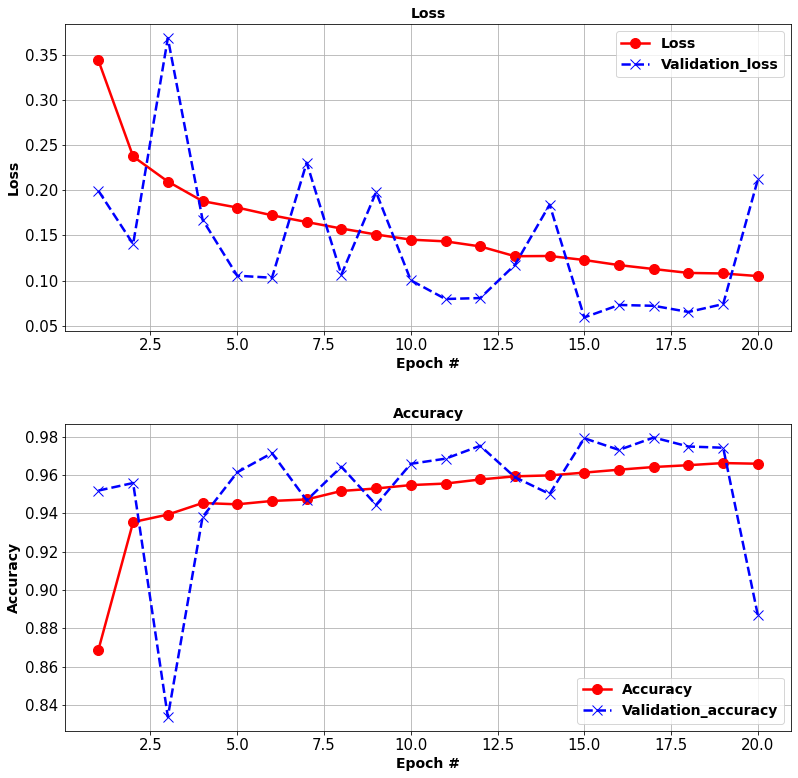

In [34]:
#Plot results of training
plot_training(res_DCNN_classification, 'KerasModel', DCNN_layers_len)

## Evaluating Results of Models on Test
### Import and Prepare Dataset
As before, we need to establish a local test directory before loading the image dataset.

In [35]:
## Set current TEST directory - OVERALL
local_test_dir = "C:\\Users\\ConnorRoth\\Documents\\Grad School\\Spring 2023\\DSCI 591\\Datasets\\FLAME 1\\Test"

In [36]:
## Grab the datset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    local_test_dir, seed=1337, image_size=image_size, batch_size=32, shuffle=True
    )

Found 8617 files belonging to 2 classes.


### Test Function Definition

In [37]:
### General Test Function Definition
def test_classification(test_ds, model):
    results_eval = model.evaluate(test_ds, batch_size=32)

    for name, value in zip(model.metrics_names, results_eval):
        print(name, ': ', value)
    print()

    return results_eval

### Model Evaluation

In [38]:
final_model = load_model(file_DCNN_model_classification)

final_model_results = test_classification(test_ds, final_model)

270/270 [==============================] - 28s 101ms/step - loss: 0.9822 - auc: 0.8153 - tp: 3354.0000 - tn: 1719.0000 - fp: 3418.0000 - fn: 126.0000 - precision: 0.4953 - recall: 0.9638 - bin_accuracy: 0.5887
loss :  0.9821738004684448
auc :  0.8152555823326111
tp :  3354.0
tn :  1719.0
fp :  3418.0
fn :  126.0
precision :  0.4952746629714966
recall :  0.9637930989265442
bin_accuracy :  0.5887199640274048

